In [51]:
import json, random
import numpy as np
from pprint import pprint
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
import requests
import urllib.request
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import pickle
import copy
import spacy
from spacy import displacy
from itertools import tee
import wikipedia
import pylcs
import string
np.set_printoptions(precision=4)

In [81]:
PUNCTUATIONS = set(string.punctuation)
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*|\(|\)|-')

In [4]:
img_meta = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data/img_metadata-Copy1.json", "r"))
print(len(img_meta))

362367


In [30]:
img_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_dataset_J_0623-Copy1.json", "r"))
print(len(img_dataset))

25467


In [76]:
pos_list = ['NUM', 'NOUN', 'ADJ', 'PROPN']

In [6]:
nlp = spacy.load('en_core_web_sm')

In [113]:
def IoU(A, B):
    intersection = len(A.intersection(B))
    union = len(A.union(B))
    return round(intersection / (union+1e-7), 2)

In [35]:
[(t.pos_, t.text) for t in nlp('"Which road is thinner, the Main road Shanischara Temple, Morena or the main road of Armenia, Gagarin?"')]

[('PUNCT', '"'),
 ('DET', 'Which'),
 ('NOUN', 'road'),
 ('AUX', 'is'),
 ('ADJ', 'thinner'),
 ('PUNCT', ','),
 ('DET', 'the'),
 ('ADJ', 'Main'),
 ('NOUN', 'road'),
 ('PROPN', 'Shanischara'),
 ('PROPN', 'Temple'),
 ('PUNCT', ','),
 ('PROPN', 'Morena'),
 ('CCONJ', 'or'),
 ('DET', 'the'),
 ('ADJ', 'main'),
 ('NOUN', 'road'),
 ('ADP', 'of'),
 ('PROPN', 'Armenia'),
 ('PUNCT', ','),
 ('PROPN', 'Gagarin'),
 ('PUNCT', '?'),
 ('PUNCT', '"')]

In [110]:
def find_sentences_from_page_for_img_data(title, page, keywords, answerwords):
    try: 
        content = wikipedia.page(title, auto_suggest=False, redirect=True).content
        paragraphs = content[:content.find('== References ==')].split('\n')
        
    except: return {}
    #records = []
    sen2score = {}
    for p in paragraphs:
        if len(p.split()) >= 10:
            #records.append(-999)
            doc = nlp(p)
            for s in doc.sents:
                if len(s) < 10: 
                    continue
                nouns_in_s = [t.text for t in s if (t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper()))]

                IoU_Q = IoU(set(nouns_in_s), keywords)
                IoU_A = IoU(set(nouns_in_s), answerwords)
                if IoU_Q -  IoU_A > 0.06:
                    sen2score[s.text] = {'scores': (IoU_Q, IoU_A, IoU_Q - IoU_A), 'link': page, 'title': title}
                #records.append(round(IoU_Q, 2))
    #print(records)

    #records = []
    for p in paragraphs:
        if len(p.split()) >= 10:
            #records.append(-999)
            doc = nlp(p)
            it1, it2 = tee(doc.sents)
            next(it2, None)
            for s1, s2 in zip(it1, it2):
                if len(s1) < 5 or len(s2) < 5 or len(s1)+len(s2) > 70 or len(s1)+len(s2) < 10: 
                    continue 
                nouns_in_s = [t.text for s in [s1, s2] for t in s if (t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper()))]

                IoU_Q = IoU(set(nouns_in_s), keywords)
                IoU_A = IoU(set(nouns_in_s), answerwords)
                if IoU_Q -  IoU_A >= 0.06:
                    sen2score[" ".join([s1.text, s2.text])] = {'scores': (IoU_Q, IoU_A, IoU_Q - IoU_A), 'link': page, 'title': title}
                    #print(s)
                #records.append(round(IoU_Q, 2))
    #print(records)
    #print(len(sen2score))
    return sen2score

In [263]:
def get_keywords_from_img_sample(k):
    Q = img_dataset[str(k)]['Q'].replace('"', '')
    doc = nlp(Q)
    keywords = set([t.text for s in doc.sents for t in s if t.pos_ in ['NUM', 'PROPN', 'ADJ', 'NOUN'] or ((not t.is_sent_start) and t.text[0].isupper())])
    keywords = keywords - PUNCTUATIONS
    
    ### Extract noun chunks
    keywords = [t.text for s in doc.sents for t in s if t.pos_ in ['NUM', 'PROPN', 'ADJ'] or ((not t.is_sent_start) and t.text[0].isupper())]
    chunks = []
    for chunk in doc.noun_chunks:
        if any([n in keywords for n in chunk.text.split()]):
            chunks.append(chunk.text)
    if not chunks: chunks.extend([t.text for s in doc.sents for t in s if t.pos_ == 'PROPN' or ((not t.is_sent_start) and t.text[0].isupper())])
    
    A = img_dataset[str(k)]['A'].replace('"', '')
    doc = nlp(A)
    answerwords = set([t.text for t in doc if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())])
    answerwords = answerwords - PUNCTUATIONS
    
    
    return keywords, answerwords, Q, A, chunks

In [241]:
x = []
for k in random.sample(range(22467), 2000):
    x.append(len(noun_chunk2candidate_page(k)))
    if len(x)%200 == 0: print(len(x))
Counter(x)        

200
400
600
800
1000
1200
1400
1600
1800
2000


Counter({0: 53,
         1: 6,
         2: 4,
         3: 2,
         4: 5,
         5: 8,
         6: 4,
         7: 3,
         8: 4,
         9: 1,
         10: 351,
         11: 9,
         12: 14,
         13: 8,
         14: 10,
         15: 10,
         16: 6,
         17: 8,
         18: 6,
         19: 3,
         20: 520,
         21: 8,
         22: 7,
         23: 6,
         24: 4,
         25: 15,
         26: 6,
         27: 5,
         28: 3,
         29: 2,
         30: 476,
         31: 2,
         32: 4,
         33: 1,
         34: 1,
         35: 1,
         36: 3,
         37: 1,
         38: 1,
         39: 1,
         40: 199,
         41: 7,
         43: 1,
         44: 4,
         45: 3,
         47: 1,
         48: 1,
         49: 2,
         50: 107,
         51: 4,
         52: 1,
         57: 1,
         58: 1,
         59: 1,
         60: 42,
         63: 1,
         64: 1,
         68: 1,
         70: 16,
         72: 1,
         74: 1,
         80: 13,


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


0.0265


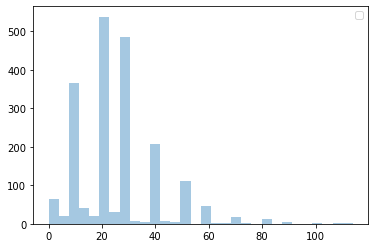

In [244]:
print(np.sum(np.array(x) == 0) / len(x))
sns.distplot(x, kde=False, bins=30)
plt.legend()

In [316]:
# Given img_dataset indx & title, find sentences with word overlap with the question
def find_sentences_from_indx_for_img(k, keywords, answerwords, chunks):
    sen2score = {}
    candidate_pages = noun_chunk2candidate_page(chunks)
    print("num of candidate pages = {}\n".format(len(candidate_pages)))
    for title in candidate_pages:
        page = "https://en.wikipedia.org/wiki/" + "_".join(title.split())
        sen2score.update(find_sentences_from_page_for_img_data(title, page, keywords, answerwords))
    sen2score = dict(sorted(sen2score.items(), key=lambda x: x[1]['scores'][0], reverse=True))
    return sen2score

In [199]:
for k in [345, 678, 456, 1297, 9099, 4738]:
    d, word_lists = find_sentences_from_indx_for_img(k)
    for k in list(d.keys())[:10]:
    
        print(k)
        print(d[k])
        print(' ')
    print(' ------------------------------------------------------------ \n')

Q =  What color did Croatia's goalkeeper wear in the 2018 FIFA World Cup Match 64, France v Croatia?
Keywords = {'Cup', 'color', 'Match', 'World', 'France', 'wear', '2018', 'goalkeeper', 'Croatia', 'FIFA', '64'}
Gold img: Croatia_WC2018_final - 
A =  "Green"
answerwords = {'Green'}
 
keywords used to find noun chunks:  ['Croatia', '2018', 'FIFA', 'World', 'Cup', 'Match', '64', 'France', 'Croatia']
noun chunk :  What color
noun chunk :  Croatia's goalkeeper wear
noun chunk :  the 2018 FIFA World Cup Match
noun chunk :  France
noun chunk :  Croatia
num of candidate pages = 30



/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


France won the 2018 FIFA World Cup, defeating Croatia 4–2 in the final match on 15 July 2018.
{'scores': (0.37, 0.0, 0.37), 'link': 'https://en.wikipedia.org/wiki/France_national_football_team', 'title': 'France national football team'}
 
In 2018, France defeated Croatia 4–2 in the final match and won the World Cup for the second time.
{'scores': (0.31, 0.0, 0.31), 'link': 'https://en.wikipedia.org/wiki/France_national_football_team', 'title': 'France national football team'}
 
Before 2018, France's only World Cup victory was in 1998 – though they had also reached the final in 2006 – while Croatia were playing in their first World Cup final.
{'scores': (0.29, 0.0, 0.29), 'link': 'https://en.wikipedia.org/wiki/2018_FIFA_World_Cup_Final', 'title': '2018 FIFA World Cup Final'}
 
The winners of each group qualified for the 2018 FIFA World Cup.
{'scores': (0.29, 0.0, 0.29), 'link': 'https://en.wikipedia.org/wiki/2018_FIFA_World_Cup_qualification', 'title': '2018 FIFA World Cup qualification

noun chunk :  light
num of candidate pages = 10

San Francisco City Hall is the seat of government for the City and County of San Francisco, California.
{'scores': (0.33, 0.0, 0.33), 'link': 'https://en.wikipedia.org/wiki/San_Francisco_City_Hall', 'title': 'San Francisco City Hall'}
 
The beauty of City Hall has not been lost on filmmakers working in San Francisco; many films have shot scenes in and around the building.
{'scores': (0.29, 0.0, 0.29), 'link': 'https://en.wikipedia.org/wiki/San_Francisco_City_Hall', 'title': 'San Francisco City Hall'}
 
The flag of the City and County of San Francisco is a flag representing San Francisco, California.
{'scores': (0.27, 0.0, 0.27), 'link': 'https://en.wikipedia.org/wiki/Flag_of_San_Francisco', 'title': 'Flag of San Francisco'}
 
San Francisco International Airport, though located in San Mateo County, is owned and operated by the City and County of San Francisco.
{'scores': (0.25, 0.0, 0.25), 'link': 'https://en.wikipedia.org/wiki/San_Franci

In [319]:
def add_html_row_x_distractor_for_img(k, sen2score, word_lists, chunks, colors=["(205, 245, 252)", "(255, 214, 222)"]):
    html = '<tr><td>{}.</td>'.format(k)
    Q = img_dataset[str(k)]['Q'].replace('"', '')
    html += '<td>Q: {}<br><br>'.format(highlight_words(word_lists, chunks, colors, Q))
    A = img_dataset[str(k)]['A'].replace('"', '')
    for gid in img_dataset[str(k)]['GoldIds']:
        img = img_meta[str(int(gid))]
        html += '<a href="{}" target="_blank"><img style="display:block; max-height:300px; max-width:100%;" src = "{}"></a>'.format(img['page'], img['src'])
        html += '<br>Title = {}<br>Description = {}<br><br>'.format(highlight_words(word_lists, [], colors, img['name'].replace("_", " ")), highlight_words(word_lists, [], colors, img['description'].replace("_", " ")))
    html += 'A: {}<br>'.format(highlight_words(word_lists, [], colors, A))
    html += '</td><td>'
    
    for s in list(sen2score.keys())[:10]:
        html += '{} --- {} '.format(highlight_words(word_lists, [], colors, s), str(sen2score[s]['scores']))
        html += '<a href="{}"  target="_blank"> {}</a><br><br>'.format(sen2score[s]['link'], sen2score[s]['title'])
    
    html += '</td></tr>'
    html += '<tr><td colspan=3><hr></td></tr>'
    return html.encode('ascii', 'xmlcharrefreplace').decode("utf-8") 

In [355]:
html = '<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.4.1/css/bootstrap.min.css">'
html += '<script src="https://code.jquery.com/jquery-3.2.1.min.js" integrity="sha256-hwg4gsxgFZhOsEEamdOYGBf13FyQuiTwlAQgxVSNgt4=" crossorigin="anonymous"></script>'
html += '<script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.4.1/js/bootstrap.min.js"></script>'
html += '<!DOCTYPE html><html><head><meta http-equiv="content-type" content="text/html; chatset="UTF-8"><body>'
html += '<script>$("img").on("error", function(){console.log($(this).attr("src"));});</script>'
html += '<style>table {border-collapse: separate;border-spacing: 10px;}\n'
html += '.chunk {text-decoration: underline solid rgb(227, 123, 253) 3px;}</style>'
html += '<table border="0" style="table-layout: fixed; width: 100%; word-break:break-word">'
html += '<tr bgcolor=lightblue style="text-align: center;"><td width=5%>Index</td><td width=35%>Q & Pos Facts</td><td width=60%>Neg Facts</td></tr>'
x = []
for k in random.sample(range(25467), 20):
    print(k)
    keywords, answerwords, Q, A, chunks = get_keywords_from_img_sample(k)
    print("Q = ", Q)
    print("Keywords = {}".format(keywords))
    print("A = ", A)
    print("answerwords = {}".format(answerwords))
    print("\nNoun chunks: ", chunks)
    print(' ')
    d = find_sentences_from_indx_for_img(k, keywords, answerwords, chunks)
    x.append(len(d))
    
    word_lists = [keywords, answerwords]
    html += add_html_row_x_distractor_for_img(k, d, word_lists, chunks, colors=["(193, 239, 253)", "(255, 214, 222)"])
    o = open('x_distractor_for_img_demo.html', 'wt')
    o.write(html)
    o.close()
html += '</table></body></html>'
o = open('x_distractor_for_img_demo.html', 'wt')
o.write(html)
o.close()

21090
Q =  Are the men in Vincent Van Gogh's paintings Self-portrait (1887) and The Smoker (Le Fumeur) (1888) wearing hats?
Keywords = ['Vincent', 'Van', 'Gogh', 'Self', '1887', 'The', 'Smoker', 'Le', 'Fumeur', '1888']
A =  Yes
answerwords = set()

Noun chunks:  ["Vincent Van Gogh's paintings", 'The Smoker', '(Le Fumeur']
 
num of candidate pages = 30



/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [321]:
wikipedia.search('the PPE vending machines')

['COVID-19 pandemic in Nevada',
 'Curative (company)',
 'Calvin Ball III',
 'Panasonic',
 'Value-added tax',
 'COVID-19 pandemic in Turkey',
 'Toronto Transit Commission incidents',
 'Shrikant Shinde',
 'Beetle',
 'List of waste management acronyms']

In [354]:
def highlight_words(word_lists, chunks, colors, sentence):
    s = copy.deepcopy(sentence)
    if "".join(chunks):
        s = re.sub(r'\s*(' + r'|'.join([re.escape(c) for c in chunks]) + r')\s*', lambda m: '<span class="chunk">{}</span>'.format(m.group()), s)
    for word_list, color in zip(word_lists, colors):
        if "".join(word_list): s = re.sub(r'\b(' + r'|'.join(word_list) + r')\b', lambda m: '<span style="background-color:rgb{}">{}</span>'.format(color, m.group()), s)
    return s

In [275]:
def noun_chunk2candidate_page(chunks):
    pages = []
    for chunk in chunks:
        pages.extend(wikipedia.search(chunk))
    return pages

In [196]:
for k in random.sample(list(img_dataset.keys()), 1):
    k=123
    print(k)
    Q = img_dataset[str(k)]['Q'].replace('"', '')
    print(Q)
    doc = nlp(Q)
    keywords = [t.text for s in doc.sents for t in s if t.pos_ in ['NUM', 'PROPN', 'ADJ'] or ((not t.is_sent_start) and t.text[0].isupper())]
    print(keywords)
    for chunk in doc.noun_chunks:
        if any([n in keywords for n in chunk.text.split()]):
            print("noun_chunk: ", chunk.text)
            print(wikipedia.search(chunk.text))
    print(' ------------------------------------------- \n')

123
Does the T & T Supermarket in Richmond have a fire extinguisher that is at the front entrance to the left of large, red Chinese letters on a silver wall?
['T', 'T', 'Supermarket', 'Richmond', 'front', 'large', 'red', 'Chinese', 'silver']
noun_chunk:  the T & T Supermarket
['T & T Supermarket', 'T&T', '99 Ranch Market', 'History of AT&T', 'T. R. Knight', 'Supermarket', 'AT&T Center', 'List of supermarket chains in Canada', 'Food City (K-VA-T)', 'Asian supermarket']
noun_chunk:  Richmond
['Richmond', 'Richmond, Virginia', 'Duke of Richmond', 'Richmond, California', 'Cedric Richmond', 'Jeff Richmond', 'Branscombe Richmond', 'Richmond Football Club', 'Richmond, London', 'Lady Margaret Beaufort']
noun_chunk:  the front entrance
['Entryway', 'Entrance pupil', 'AEC Routemaster', 'Ross Castle', 'Porch', 'Dulce et decorum est pro patria mori', '5, The Grove', 'Wardour Castle', 'Parliament Building (Quebec)', 'Cornelius Vanderbilt II House']
noun_chunk:  large, red Chinese letters
['Vermilio

In [64]:
new_txt_data = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/output_mine_all_schema.json", "r"))
print(len(new_txt_data))
'''
temp = {}
count = 0
for i in new_txt_data:
    temp[count] = copy.deepcopy(i)
    temp[count]['Q'] = temp[count]['Question']
    temp[count]['A'] = temp[count]['Answer']
    del temp[count]['Question']
    del temp[count]['Answer']
    count += 1
json.dump(temp, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/output_mine_all_schema.json", "w"), indent=4)
'''

7921


'\ntemp = {}\ncount = 0\nfor i in new_txt_data:\n    temp[count] = copy.deepcopy(i)\n    temp[count][\'Q\'] = temp[count][\'Question\']\n    temp[count][\'A\'] = temp[count][\'Answer\']\n    del temp[count][\'Question\']\n    del temp[count][\'Answer\']\n    count += 1\njson.dump(temp, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/output_mine_all_schema.json", "w"), indent=4)\n'

In [62]:
def sample2keywords(k):
    Q = new_txt_data[str(k)]['Q']
    doc = nlp(Q)
    keywords = set([t.text for s in doc.sents for t in s if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())])

    keywords = keywords - PUNCTUATIONS        

    A = new_txt_data[str(k)]['A']
    doc = nlp(A)
    answerwords = set([t.text for t in doc if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())])
    answerwords = answerwords - PUNCTUATIONS

    goldfactwords = set()
    titlewords = set()
    Q_A_words = keywords.union(answerwords)
    for f in new_txt_data[str(k)]['SupportingFacts']:
        doc = nlp(f['fact'])
        goldfactwords = goldfactwords.union(set([t.text for t in doc if t.pos_ in pos_list or ((not t.is_sent_start) and t.text[0].isupper())]) - Q_A_words)
        fact_title_raw = ' '.join(urllib.parse.unquote(f['url']).split('/')[-1].split('_'))
        fact_title = pattern.sub('', fact_title_raw)
        titlewords = titlewords.union(fact_title.split())
    goldfactwords = goldfactwords - PUNCTUATIONS 
    titlewords = titlewords - PUNCTUATIONS

    word_lists = [titlewords, keywords, goldfactwords, answerwords]
    return word_lists

In [74]:
def add_html_row_vis_ori_dataset(k, word_lists, colors = ["(223, 255, 238)", "(193, 239, 253)", "(253, 252, 152)", "(255, 214, 222)"]):
    html = ""
    html += '<tr><td>{}.</td><td>Q: {}<br>'.format(k, highlight_words(word_lists, colors, new_txt_data[str(k)]['Q']))
    for f in new_txt_data[str(k)]['SupportingFacts']:
        html += '<br><br>&nbsp;&nbsp;{}'.format(highlight_words(word_lists, colors, f['fact']))
        html += '<a href="{}"> link</a>'.format(f['url'])
    html += '<br><br>A: {}<br>'.format(highlight_words(word_lists, colors, new_txt_data[str(k)]['A']))
    html += '</td><td>'
    
    for f in new_txt_data[str(k)]['DistractorFacts']:            
            html += highlight_words(word_lists, colors, f['fact'])
            html += '<a href="{}"> {}</a><br><br>'.format(f['url'], f['title'])
    html += '</td></tr>'
    html += '<tr><td colspan=3><hr></td></tr>'
    return html

In [86]:
sampled_indx = random.sample(range(7921), 25)

In [103]:
html = "<html><body>"
html += '<table border="0" style="table-layout: fixed; width: 100%; word-break:break-word">'
html += '<tr bgcolor=gray><td width=5%>Index</td><td width=35%>Q & Pos Facts</td><td width=60%>Neg Facts</td></tr>'
count = 0
for k in sampled_indx:
    count += 1
    word_lists = sample2keywords(k)[:2]
    html += add_html_row_vis_ori_dataset(k, word_lists)
    o = open('txt_dataset_vis.html', 'wt')

    o.write(html)
    o.close()
html += '</table></body></html>'
o = open('txt_dataset_vis.html', 'wt')

o.write(html)
o.close()

In [102]:
colors = ["(223, 255, 238)", "(193, 239, 253)", "(253, 252, 152)", "(255, 214, 222)"]
highlight_words(sample2keywords(3816), colors, 'What kind of effect are artificial harmonics and vibrato ?')

'What  <span style="background-color:rgb(193, 239, 253)">kind </span> of  <span style="background-color:rgb(193, 239, 253)">effect </span> are  <span style="background-color:rgb(193, 239, 253)">artificial </span>  <span style="background-color:rgb(193, 239, 253)">harmonics </span> and  <span style="background-color:rgb(193, 239, 253)">vibrato </span> ?'

In [88]:
[(t.pos_, t.text) for t in nlp('What kind of effect are artificial harmonics and vibrato ?')]

[('PRON', 'What'),
 ('NOUN', 'kind'),
 ('ADP', 'of'),
 ('NOUN', 'effect'),
 ('AUX', 'are'),
 ('ADJ', 'artificial'),
 ('NOUN', 'harmonics'),
 ('CCONJ', 'and'),
 ('NOUN', 'vibrato'),
 ('PUNCT', '?')]

In [89]:
sample2keywords(3816)

[{'Csárdás', 'Monti', 'Vibrato'},
 {'artificial', 'effect', 'harmonics', 'kind', 'vibrato'},
 {'24',
  '5',
  'Czardas',
  'Italian',
  'Meno',
  'Monti',
  'Vibrato',
  'change',
  'e',
  'expression',
  'finger',
  'help',
  'higher',
  'instrumental',
  'lento',
  'media',
  'music',
  'musical',
  'note',
  'octaves',
  'participle',
  'past',
  'pianoforte',
  'pitch',
  'quasi',
  'regular',
  'section',
  'semitones',
  'string',
  'two',
  'vibrare',
  'violin',
  'violinist',
  'violino',
  'vocal'},
 {'Musical', 'effects'}]